In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov 28 15:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    45W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install transformers
%pip install segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline

import os
import cv2
import numpy as np
import glob
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import random

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

import pandas as pd

import pickle

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# import picked dataset

path_data = '/content/gdrive/MyDrive/6688. HTW/PM Lab/data/'

image_dataset = pickle.load(open(path_data+'image_dataset_2000_960x512_Median_Filtered', "rb"))
mask_dataset = pickle.load(open(path_data+'mask_dataset_2000_960x512_Median_Filtered', "rb"))


image:  (2000, 512, 960, 3)
mask:  (2000, 512, 960)
image:  (2000, 512, 960, 3)
mask:  (2000, 512, 960, 1)


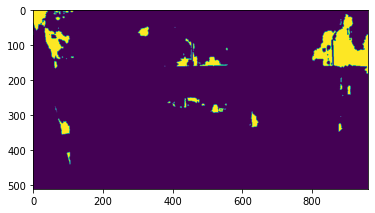

In [ ]:
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)
plt.imshow(mask_dataset[0])

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)


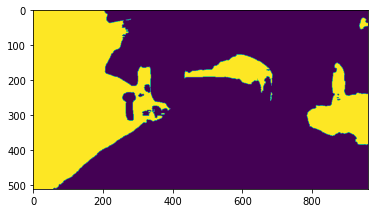

In [ ]:
plt.imshow(mask_dataset[1,:,:,0])

In [ ]:
# split
X_train_pp, X_test_pp, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)
# pp=pre-processing -> we need to use the original for illustration


In [ ]:
print(X_train_pp.shape)
print(X_test_pp.shape)
print(y_train.shape)
print(y_test.shape)

(1600, 512, 960, 3)
(400, 512, 960, 3)
(1600, 512, 960, 1)
(400, 512, 960, 1)


In [ ]:
try:
    del model
except:
    pass
    
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train_pp)
X_test = preprocess_input(X_test_pp)

# define the model
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.8), 'mse']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

# print(model.summary())

In [ ]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=10,
                        epochs=5,
                        verbose=1,
                        validation_data=(X_test,y_test))

Epoch 1/5
160/160 [==============================] - 161s 880ms/step - loss: 0.2573 - accuracy: 0.8959 - iou_score: 0.5102 - mse: 0.0766 - val_loss: 0.3564 - val_accuracy: 0.8850 - val_iou_score: 0.5233 - val_mse: 0.0895
Epoch 2/5
160/160 [==============================] - 143s 891ms/step - loss: 0.1785 - accuracy: 0.9263 - iou_score: 0.6338 - mse: 0.0533 - val_loss: 0.3319 - val_accuracy: 0.8678 - val_iou_score: 0.3123 - val_mse: 0.0996
Epoch 3/5
160/160 [==============================] - 142s 891ms/step - loss: 0.1580 - accuracy: 0.9351 - iou_score: 0.6674 - mse: 0.0472 - val_loss: 0.2144 - val_accuracy: 0.9124 - val_iou_score: 0.5299 - val_mse: 0.0642
Epoch 4/5
160/160 [==============================] - 143s 892ms/step - loss: 0.1524 - accuracy: 0.9370 - iou_score: 0.6829 - mse: 0.0456 - val_loss: 0.2298 - val_accuracy: 0.9226 - val_iou_score: 0.6058 - val_mse: 0.0583
Epoch 5/5
160/160 [==============================] - 142s 890ms/step - loss: 0.1405 - accuracy: 0.9426 - iou_score: 

In [ ]:
path_save = '/content/gdrive/MyDrive/6688. HTW/PM Lab/data/'
model.save(path_save+'model_2000_960x512_Median_Filtered.hdf5')

try:
    del model
except:
    pass

from keras.models import load_model
model = load_model(path_save+'model_2000_960x512_Median_Filtered.hdf5', compile=False)


In [ ]:
model = load_model(path_save+'model_4000_512x256_Median_Filtered.hdf5', compile=False)


In [ ]:
# print(history.history.keys())

dict_keys(['loss', 'accuracy', 'iou_score', 'mse', 'val_loss', 'val_accuracy', 'val_iou_score', 'val_mse'])


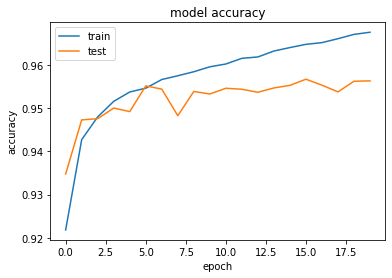

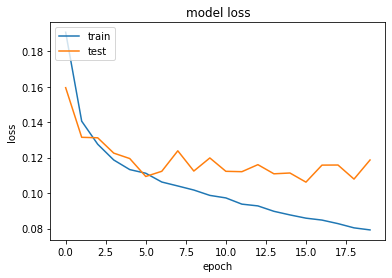

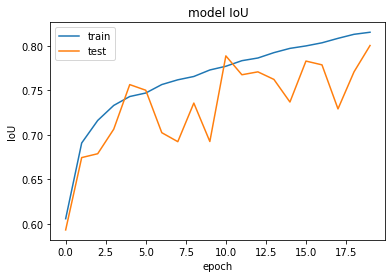

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('model IoU')
plt.ylabel('IoU')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

In [ ]:
import tensorflow as tf

test set index:  1084
1/1 [==============================] - 1s 1s/step


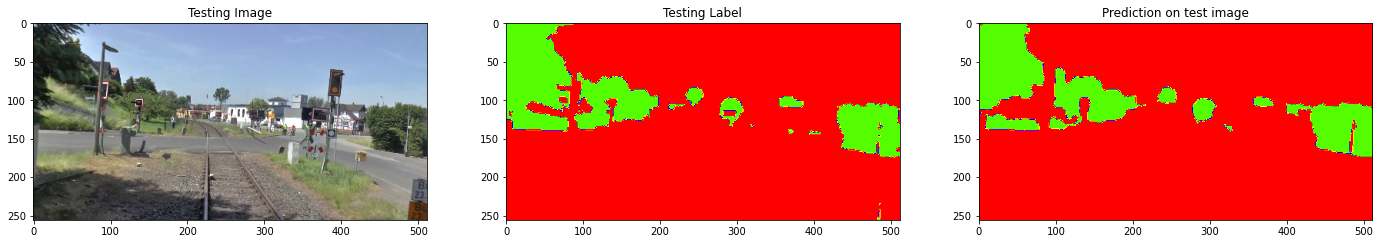

In [ ]:
test_img_number = random.randint(0, len(X_test))
print('test set index: ',test_img_number)
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img_to_show, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img[:,:,0], cmap='prism')
plt.show()

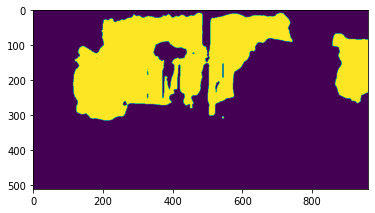

In [ ]:
plt.imshow(predicted_img[:,:,0])